In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import rcParams
import celerite
from celerite import terms
from celerite.modeling import Model
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from astropy.table import Table

rcParams['figure.figsize'] = (16.0, 8.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('miyake12.csv')

In [3]:
@jit
def super_gaussian(t, start_time, duration, area):
    middle = start_time+duration/2.
    height = area/duration
    return height*jnp.exp(- ((t-middle)/(1./1.93516*duration))**16.)

@jit
def miyake_event_fixed_solar(t, start_time, duration, phase, area):
    height = super_gaussian(t, start_time, duration, area)
    prod =  cf.steady_state_production + 0.18 * cf.steady_state_production * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod

In [4]:
start_time, duration, phase, area = [775., 1./12, np.pi/2., 81./12]
t = np.arange(760, 788)
# control_points = miyake_event_fixed_solar(t, start_time, duration, phase, area)
control_points = jnp.array(np.random.rand(len(cf.d14c_data)))
cf.prepare_function(use_control_points=True, years=t, control_points=control_points)

In [5]:
sampler = cf.sampling(control_points, burnin=200, production=300, log_like=True)

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:48<00:00,  1.85it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [02:43<00:00,  1.83it/s]


Text(0.5, 1.0, 'Recovered Production Rate')

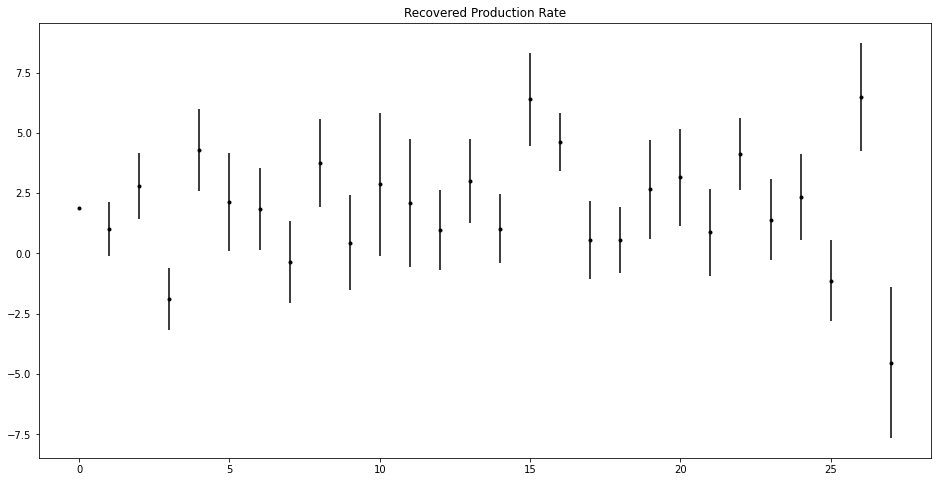

In [8]:
recover_prod = np.mean(sampler.flatchain, axis=0)
recover_error = np.std(sampler.flatchain, axis=0)
plt.errorbar(np.arange(len(recover_prod)), recover_prod, yerr=recover_error, fmt=".k")
plt.title("Recovered Production Rate")

In [11]:
control_points2 = miyake_event_fixed_solar(t, start_time, duration, phase, area)
cf.prepare_function(use_control_points=True, years=t, control_points=control_points2)
sampler = cf.sampling(control_points, burnin=200, production=300, log_like=True)

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [02:45<00:00,  1.82it/s]


Text(0.5, 1.0, 'Recovered Production Rate')

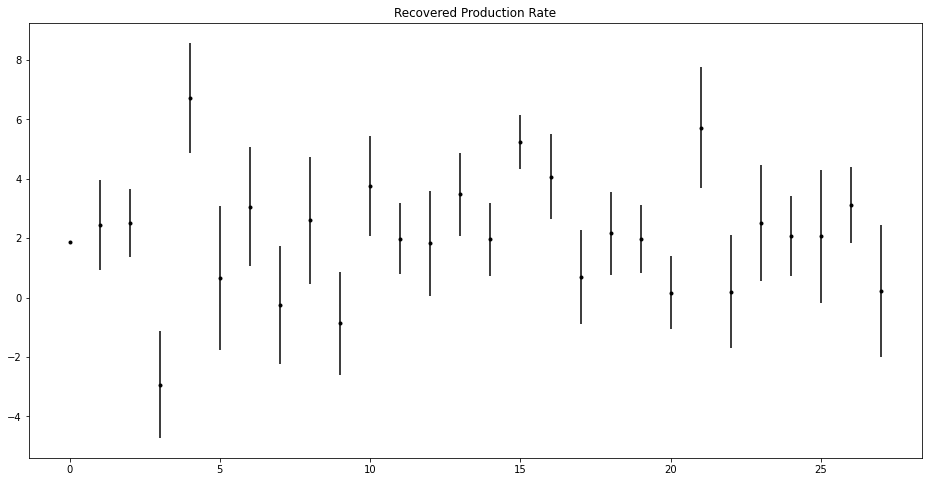

In [12]:
recover_prod = np.mean(sampler.flatchain, axis=0)
recover_error = np.std(sampler.flatchain, axis=0)
plt.errorbar(np.arange(len(recover_prod)), recover_prod, yerr=recover_error, fmt=".k")
plt.title("Recovered Production Rate")